### Import Necessary Libraries

In [29]:
# Machine learning 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score 
import seaborn as sns
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid') 
import warnings 
warnings.filterwarnings("ignore")
import requests
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR  
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [30]:
gdp_path = '/Users/marianellasalinas/Desktop/GDPThesis.xlsx'
growth_path = '/Users/marianellasalinas/Downloads/US_GDP2013to2023.xlsx'
cpi_path = '/Users/marianellasalinas/Desktop/CPIThesis.xlsx'
cpi_data = pd.read_excel(cpi_path)
gdp_data= pd.read_excel(gdp_path)

### `fetch_data` 

This function gets specific company data from the SimFin API by making a request with an authorization token. This project uses "AAPL", "WMT", "PEP", and  "JPM" stock tickers that can be tested out.



In [31]:
def fetch_data(ticker):
    
    url = f"https://backend.simfin.com/api/v3/companies/prices/compact?ticker={ticker}&ratios=true&asreported=true&end=2023-12-30"
    headers = {
        "accept": "application/json",
        "Authorization": "Apxo7JQwUqEgl4R2cEduIcsNe6MC8vox"
    }
    
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        df = response.json()
        
        columns = df[0]['columns']
        rows = df[0]['data']

        raw_data = pd.DataFrame(rows, columns=columns)

        data = raw_data[['Date', 'Opening Price', 'Highest Price', 'Lowest Price', 
                         'Last Closing Price', 'Adjusted Closing Price', 'Trading Volume']]
        data.columns = ['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Volume']
        data['Date'] = pd.to_datetime(data['Date'])

        return data
    else:
        print("Failed to fetch data:", response.status_code)


ticker = "AAPL" 
data = fetch_data(ticker)
print(data)


           Date    Open    High     Low    Last   Close     Volume
0    2014-05-05   21.08   21.46   21.07   21.46   18.90  287067487
1    2014-05-06   21.49   21.59   21.23   21.23   18.70  374564775
2    2014-05-07   21.26   21.33   20.99   21.15   18.63  282864683
3    2014-05-08   21.01   21.23   20.94   21.00   18.60  230297430
4    2014-05-09   20.88   20.94   20.73   20.91   18.52  291597892
...         ...     ...     ...     ...     ...     ...        ...
2427 2023-12-22  195.18  195.41  192.97  193.60  193.35   37149570
2428 2023-12-26  193.61  193.89  192.83  193.05  192.80   28919310
2429 2023-12-27  192.49  193.50  191.09  193.15  192.90   47899806
2430 2023-12-28  194.14  194.66  193.17  193.58  193.33   34049898
2431 2023-12-29  193.90  194.40  191.72  192.53  192.29   42672148

[2432 rows x 7 columns]


### `stock_background` 

This function displays the trading volume and the open and close prices of the selected ticker. 


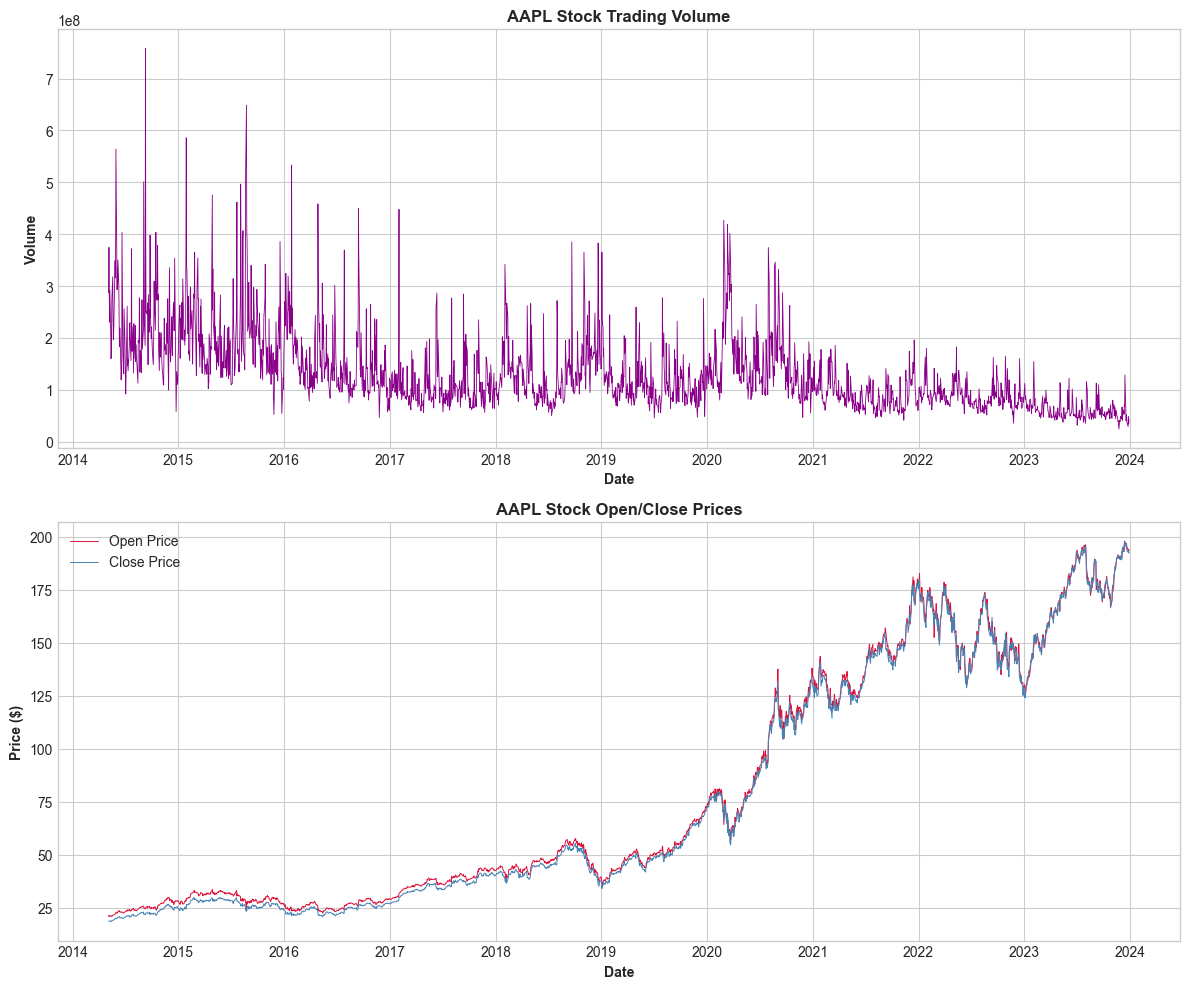

In [32]:
def stock_background(ticker, data):
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(12, 10))

    # Trading volume
    plt.subplot(2, 1, 1) 
    plt.plot(data['Date'], data['Volume'], linestyle='-', color='darkmagenta', linewidth=0.6)
    plt.title(f'{ticker} Stock Trading Volume', fontweight='bold')
    plt.xlabel('Date', fontweight='bold')
    plt.ylabel('Volume', fontweight='bold')
    
    # Open/close prices
    plt.subplot(2, 1, 2) 
    plt.plot(data['Date'], data['Open'], linestyle='-', color='crimson', label='Open Price',  linewidth=0.7)
    plt.plot(data['Date'], data['Close'], linestyle='-', color='steelblue', label='Close Price',  linewidth=0.7)
    plt.title(f'{ticker} Stock Open/Close Prices', fontweight='bold')
    plt.xlabel('Date', fontweight='bold')
    plt.ylabel('Price ($)', fontweight='bold')
    plt.legend()

    # Display 
    plt.tight_layout() 
    plt.show()

stock_background(ticker, data)

### `stock_svr` 

This function makes the support vector regression model without economic features. First, it filters data to begin at the start of 2019. Then, it prepares the features and tareet variable which is the future price. The data is then spit 80/20 and the features are standarized. The SVR model is initialized and trained with specific C parameter. Lastly, the MSE for train and test is displayed as well as the graph.


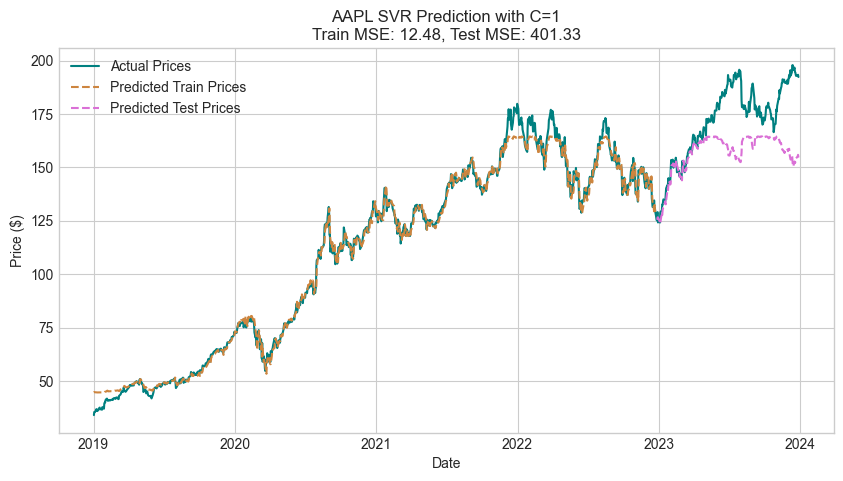

In [33]:
def stock_svr(ticker, data, c):

    data = data[data['Date'] >= '2019-1-1']

    # FInd the average stock price 
    data['Average Price'] = data[['Open', 'High', 'Low', 'Last', 'Close']].mean(axis=1)

    data['Future Close'] = data['Close'].shift(-1)

    # drop last row
    data = data[:-1]

    X = data[['Open', 'High', 'Low', 'Last', 'Average Price']]
    y = data['Future Close']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    scaler = StandardScaler() # initalize model
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svr = SVR(kernel='rbf', C=c, gamma='scale') # Train the SVR model
    svr.fit(X_train_scaled, y_train)

    y_pred_train = svr.predict(X_train_scaled) # Predict on training and testing data
    y_pred_test = svr.predict(X_test_scaled)

    # Find mse 
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    dates = pd.to_datetime(data['Date'])

    # Display
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(10, 5))
    plt.plot(dates, y, color='teal', label='Actual Prices')
    split_point = int(len(y) * 0.8)
    plt.plot(dates[:split_point], y_pred_train, color='peru', linestyle='--', label='Predicted Train Prices')
    plt.plot(dates[split_point:], y_pred_test, color='orchid', linestyle='--', label='Predicted Test Prices')
    plt.title(f'{ticker} SVR Prediction with C={c}\nTrain MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.show()

stock_svr(ticker,data, 1)

### Economic Data 

- GDP
- CPI 
- Consumption 

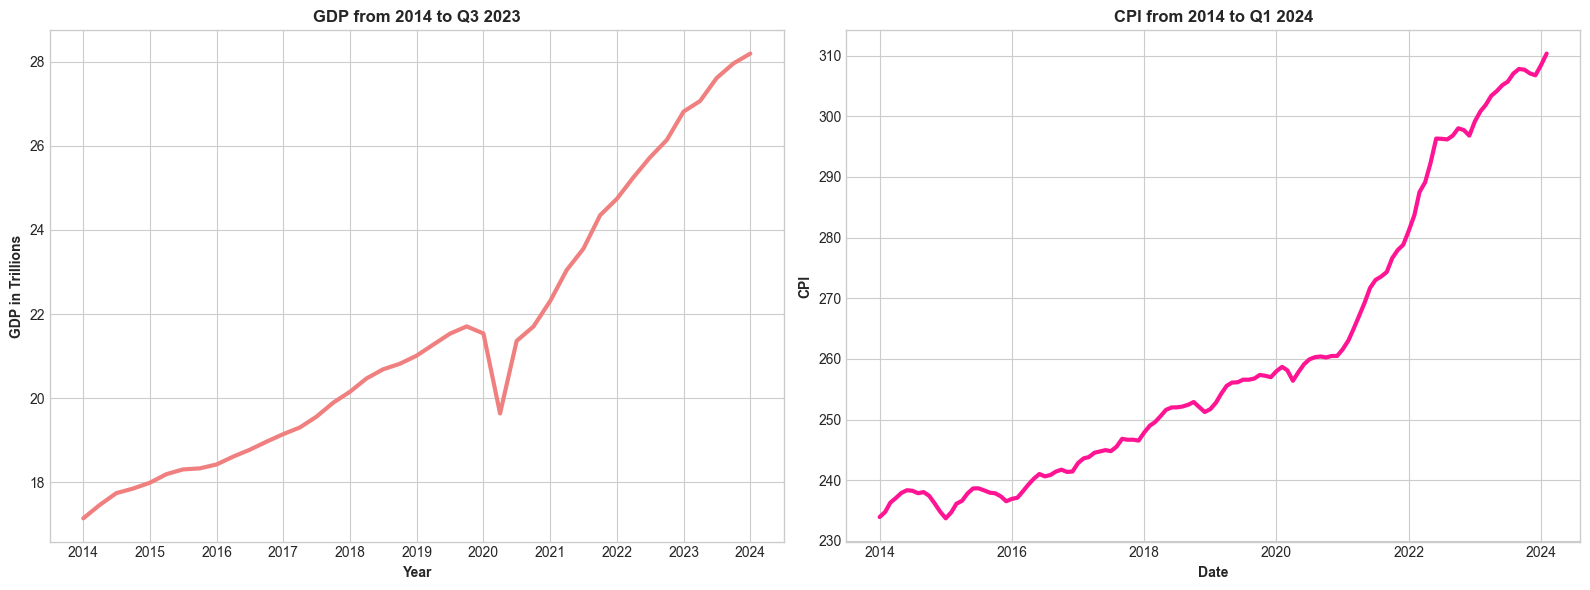

In [34]:
def econ_background(gdp_path, cpi_path):
    gdp_data = pd.read_excel(gdp_path)
    gdp_data['DATE'] = pd.to_datetime(gdp_data['DATE'])
    gdp_data.columns = ['Date', 'GDP']
    gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
    gdp_data['GDP'] = gdp_data['GDP'] / 1000
    cpi_data = pd.read_excel(cpi_path)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    # Plot GDP data
    gdp_data = gdp_data[gdp_data['Date'] >= '2014-1-1']
    ax1.plot(gdp_data['Date'], gdp_data['GDP'], linestyle='-', color='lightcoral', linewidth=3)
    ax1.set_title('GDP from 2014 to Q3 2023', fontweight='bold')
    ax1.set_xlabel('Year', fontweight='bold')
    ax1.set_ylabel('GDP in Trillions', fontweight='bold')

    # Plot CPI data
    ax2.plot(cpi_data['Date'], cpi_data['CPI'], linestyle='-', color='deeppink', linewidth=3)
    ax2.set_title('CPI from 2014 to Q1 2024', fontweight='bold')
    ax2.set_xlabel('Date', fontweight='bold')
    ax2.set_ylabel('CPI', fontweight='bold')


    plt.tight_layout()
    plt.show()

econ_background(gdp_path, cpi_path)


### GDP and CPI Stock Data Processing 
The `quarter_range` variable is used to filter the `gdp_data` dataframe for these specific quarters. This filtered data is merged with another dataset `data`. An exponential weighted moving average of the GDP column is calculated to assign more weight to the more recent observations in gdp. Then, the data is changed by merging CPI data based on the 'MonthYear'.


In [35]:
quarter_range = pd.date_range(start='1/1/2014', end='10/1/2023', freq='QS-JAN')

gdp_data.columns = ['Date', 'GDP']
gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
gdp_stock = gdp_data[gdp_data['Date'].isin(quarter_range)].copy()
                                                                            

gdp_stock = pd.merge_asof(data.sort_values('Date'), gdp_stock.sort_values('Date'), on='Date', direction='backward')

alpha = 0.1 
gdp_stock['Weighted GDP'] = gdp_stock['GDP'].ewm(alpha=alpha).mean()

gdp_stock['Date'] = pd.to_datetime(gdp_stock['Date'])
cpi_data['Date'] = pd.to_datetime(cpi_data['Date'])

gdp_stock['MonthYear'] = gdp_stock['Date'].dt.to_period('M')
cpi_data['MonthYear'] = cpi_data['Date'].dt.to_period('M')


gdp_stock = pd.merge(gdp_stock, cpi_data[['MonthYear', 'CPI']], on='MonthYear', how='left')

gdp_stock.drop(['MonthYear', 'CPI_x', 'CPI_y'], axis=1, errors='ignore', inplace=True)

gdp_stock['Average Price'] = gdp_stock[['Open', 'High', 'Low', 'Last', 'Close']].mean(axis=1)

gdp_stock.tail(70)


,Date,Open,High,Low,Last,Close,Volume,GDP,Weighted GDP,CPI,Average Price
2362,2023-09-21,174.55,176.30,173.86,173.93,173.49,63149116,27610.128,27608.778442,307.789,174.426
2363,2023-09-22,174.67,177.08,174.05,174.79,174.34,56725385,27610.128,27608.913397,307.789,174.986
2364,2023-09-25,174.20,176.97,174.15,176.08,175.63,46172740,27610.128,27609.034858,307.789,175.406
2365,2023-09-26,174.82,175.20,171.66,171.96,171.52,64588945,27610.128,27609.144172,307.789,173.032
2366,2023-09-27,172.62,173.04,169.05,170.43,169.99,66921808,27610.128,27609.242555,307.789,171.026
...,...,...,...,...,...,...,...,...,...,...,...
2427,2023-12-22,195.18,195.41,192.97,193.60,193.35,37149570,27956.998,27956.303980,306.746,194.102
2428,2023-12-26,193.61,193.89,192.83,193.05,192.80,28919310,27956.998,27956.373382,306.746,193.236
2429,2023-12-27,192.49,193.50,191.09,193.15,192.90,47899806,27956.998,27956.435844,306.746,192.626
2430,2023-12-28,194.14,194.66,193.17,193.58,193.33,34049898,27956.998,27956.492060,306.746,193.776


### `stock_econ_svr` 

This function makes the support vector regression model with GDP and CPI. First, it filters data to begin at the start of 2019. Then, it prepares the features and target variable which is the future price. The data is then spit 80/20 and the features are standarized. The SVR model is initialized and trained with specific C parameter. Lastly, the MSE for train and test is displayed as well as the graph.


Train MSE: 5.917387697664462
Test MSE: 502.2530052035437


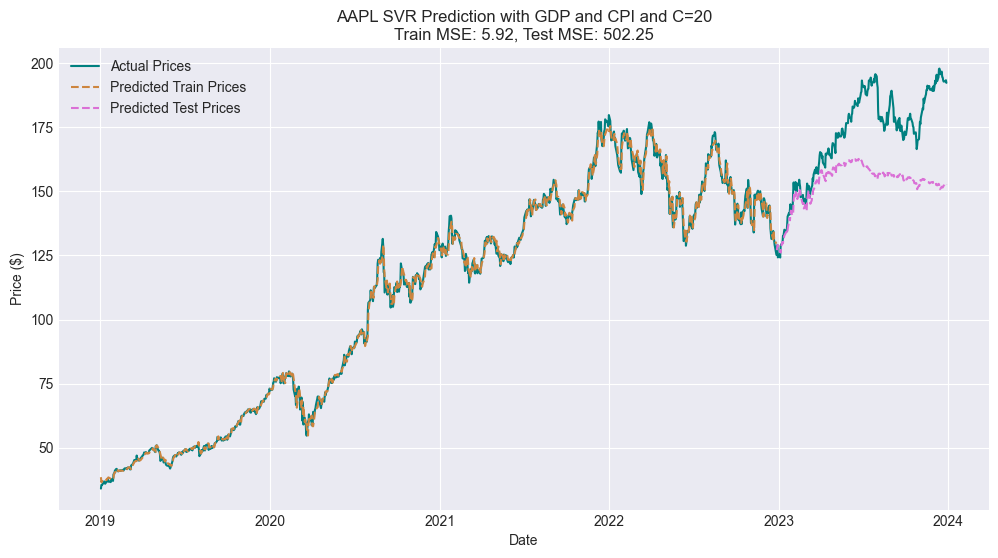

In [36]:
def stock_econ_svr(ticker, data, c):
    plt.style.use('seaborn-darkgrid')
    data = data[data['Date'] >= '2019-1-1']

    data['Date'] = pd.to_datetime(data['Date'])
    data['Future Close'] = data['Close'].shift(-1)

    data = data[:-1]
    
    X = data[['Open', 'High', 'Low', 'Last', 'Average Price', 'Weighted GDP', 'CPI']]
    y = data['Future Close']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svr = SVR(kernel='rbf', C=c, gamma='scale')
    svr.fit(X_train_scaled, y_train)

    y_pred_train = svr.predict(X_train_scaled)
    y_pred_test = svr.predict(X_test_scaled)

    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)

    print(f"Train MSE: {train_mse}") #Show error 
    print(f"Test MSE: {test_mse}")

    # Plotting
    plt.figure(figsize=(12, 6))
    dates = data['Date']
    split_point = int(len(y) * 0.8)

    plt.plot(dates, y, color='teal', label='Actual Prices')
    plt.plot(dates[:split_point], y_pred_train, color='peru', linestyle='--', label='Predicted Train Prices')
    plt.plot(dates[split_point:], y_pred_test, color='orchid', linestyle='--', label='Predicted Test Prices')

    plt.title(f'{ticker} SVR Prediction with GDP and CPI and C={c}\nTrain MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.show()


stock_econ_svr(ticker, gdp_stock, 20)